## Graph analysis

In [1]:
import json
import pandas as pd
from pathlib import Path
import sys
import networkx as nx
import matplotlib.pyplot as plt



In [2]:
from pathlib import Path

# Define the path ('.' means current directory)
p = Path('.')

# List only directories
folders = [x for x in p.iterdir() if x.is_dir()]

print(folders)

[WindowsPath('financial_results')]


In [42]:
df_all_technologies = pd.read_csv("all_technologies_compiled.csv")


df_all_technologies = df_all_technologies.dropna(subset=['company_name', 'technology_name'])

In [43]:

# --- 1. Load the JSON file ---
try:
    with open('tech_classification.json', 'r') as f:
        tech_data = json.load(f)
except FileNotFoundError:
    print("Error: 'tech_classification.json' not found.")
    print("Please make sure the file is in the same directory as your script.")

except json.JSONDecodeError:
    print("Error: Could not decode the JSON file. It might be corrupted.")

In [37]:
df_all_technologies

,source_file,company_name,symbol,year,quarter,technology_name,technology_sentiment,investment_action,investment_horizon,profit_outlook,rd_investment,revenue_impact,mentioned_by,technology_name_secondary
0,AAPL_Apple Inc..json,Apple Inc.,AAPL,2024,1,App Store,neutral,maintaining,ongoing,unclear,unclear,unclear,Tim Cook,NaN
1,AAPL_Apple Inc..json,Apple Inc.,AAPL,2024,1,NFC,positive,investing,ongoing,unclear,unclear,unclear,Tim Cook,NaN
2,AAPL_Apple Inc..json,Apple Inc.,AAPL,2024,1,AI,positive,investing,ongoing,high potential,unclear,unclear,Tim Cook,NaN
3,AAPL_Apple Inc..json,Apple Inc.,AAPL,2024,1,GenAI,positive,investing,ongoing,high potential,unclear,unclear,Tim Cook,NaN
4,AAPL_Apple Inc..json,Apple Inc.,AAPL,2024,1,Apple Silicon,positive,maintaining,ongoing,unclear,unclear,unclear,Krish Sankar,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,C_Citigroup Inc..json,Citigroup Inc.,C,2024,2,Cloud Computing,positive,investing,long-term,high potential,unclear,unclear,Jane Fraser,NaN
1913,C_Citigroup Inc..json,Citigroup Inc.,C,2024,3,Transformation,positive,investing,ongoing,unclear,unclear,unclear,Jane Fraser,NaN
1914,C_Citigroup Inc..json,Citigroup Inc.,C,2024,3,Simplification,positive,maintaining,ongoing,unclear,unclear,unclear,Mark Mason,NaN
1915,C_Citigroup Inc..json,Citigroup Inc.,C,2024,4,AI,positive,investing,ongoing,unclear,unclear,unclear,Jane Fraser,NaN


In [44]:

# 3. Prepare data for the DataFrame

data_list = []

tech_map = {}

# We iterate over the dictionary's items
for main_label, sub_technologies_list in tech_data.items():
    for sub_tech in sub_technologies_list:
        # We use .lower() to ensure matching is case-insensitive
        tech_map[sub_tech.lower()] = main_label

original_column_lowercase = df_all_technologies['technology_name'].str.lower()

# Use .map() to create the new 'techonology' column

df_all_technologies['technology'] = original_column_lowercase.map(tech_map)


# We'll fill 'NaN' values in the 'new_label' column with their original 'technology_name'

df_all_technologies = df_all_technologies.dropna(subset=['technology'])


## Graph

In [46]:
#building graph
CompanyTechGraph = nx.Graph()


# --- 3. Add 'Company' nodes ---

company_df = df_all_technologies[['company_name', 'symbol']].drop_duplicates()
print(f"Adding {len(company_df)} 'Company' nodes...")


for _, row in company_df.iterrows():
    CompanyTechGraph.add_node(
        row['company_name'],
        type='Company',
        symbol=row['symbol']
    )


Adding 102 'Company' nodes...


In [48]:

# --- 4. Add 'Technology' nodes ---

tech_nodes = df_all_technologies['technology'].unique()
print(f"Adding {len(tech_nodes)} 'Technology' nodes...")

for tech_name in tech_nodes:
    CompanyTechGraph.add_node(
        tech_name,
        type='Technology'
    )

# --- 5. Add 'MENTIONS' edges ---

print(f"Adding {len(df_all_technologies)} 'MENTIONS' edges...")

for _, row in df_all_technologies.iterrows():
    CompanyTechGraph.add_edge(
        row['company_name'],
        row['technology'],
        type='MENTIONS',
        sentiment=row['technology_sentiment'],
        investment=row['investment_action'],
        profit_outlook=row['profit_outlook'],
        mentioned_by=row['mentioned_by'],
        year=row['year'],
        quarter=row['quarter']
    )

# --- 6. Print Summary ---
print(f"\n✅ Company-Technology Graph built successfully!")
print(f"Total nodes: {CompanyTechGraph.number_of_nodes():,}")
print(f"Total edges: {CompanyTechGraph.number_of_edges():,}")

Adding 27 'Technology' nodes...
Adding 1181 'MENTIONS' edges...

✅ Company-Technology Graph built successfully!
Total nodes: 129
Total edges: 508


In [49]:
# You can filter nodes to verify the two sets
company_nodes = [n for n, d in CompanyTechGraph.nodes(data=True) if d['type'] == 'Company']
tech_nodes = [n for n, d in CompanyTechGraph.nodes(data=True) if d['type'] == 'Technology']

print(f"  - Company nodes found: {len(company_nodes):,}")
print(f"  - Technology nodes found: {len(tech_nodes):,}")

  - Company nodes found: 102
  - Technology nodes found: 27


In [50]:
G = CompanyTechGraph


# --- 2. Create a Color Map ---
# (This remains the same)
color_map = []
for node, data in G.nodes(data=True):
    if data.get('type') == 'Company':
        color_map.append('skyblue')  # Color for companies
    elif data.get('type') == 'Technology':
        color_map.append('lightgreen')  # Color for technologies
    else:
        color_map.append('grey')
print("Color map generated.")

custom_labels = {}
for node, data in G.nodes(data=True):
    if data.get('type') == 'Technology':
        custom_labels[node] = node
        
print(f"Custom label dictionary created. It contains {len(custom_labels)} labels.")

Color map generated.
Custom label dictionary created. It contains 27 labels.


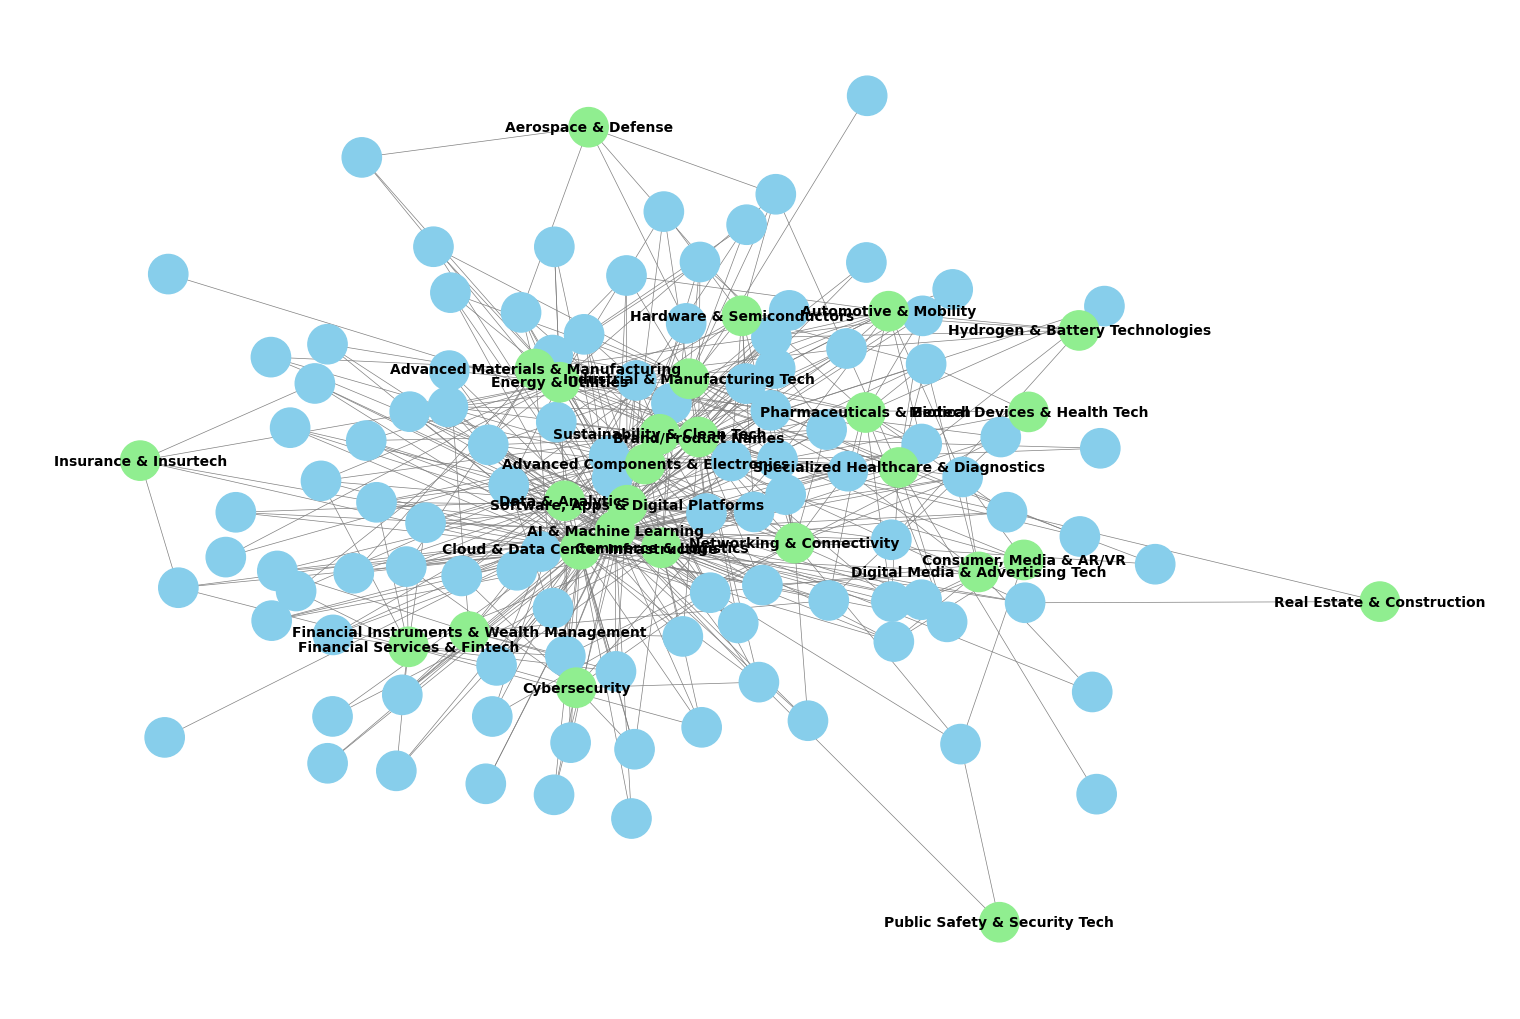

In [51]:

# --- 4. Plot the Graph ---
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.35, iterations=40, seed=42)

# Draw the graph
nx.draw(G,
        pos,
        node_color=color_map,
        labels=custom_labels,  # <-- Use our custom label dictionary
        node_size=800,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        width=0.5
       )

## Centrality Analysis

In [52]:

# --- 1. Create a Sample CompanyTechGraph ---
# (Using the same sample graph as before)
G = CompanyTechGraph


# --- 2. Calculate Centrality Measures ---

# Degree Centrality (Normalized)
# This is fast.
print("Calculating Degree Centrality...")
deg_centrality = nx.degree_centrality(G)

# Betweenness Centrality (Normalized)
# *** WARNING: This is VERY SLOW on large graphs. ***
print("Calculating Betweenness Centrality...")
# For your real 1500-node graph, you might want to use a sample:
# between_centrality = nx.betweenness_centrality(G, k=500, normalized=True)
between_centrality = nx.betweenness_centrality(G, normalized=True)

# Eigenvector Centrality
# This can sometimes fail on complex graphs, so we use max_iter
# This is reasonably fast.
print("Calculating Eigenvector Centrality...")
try:
    eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector Centrality did not converge. Skipping.")
    eigen_centrality = {node: 0 for node in G.nodes()} # Create empty dict

print("Centrality calculations complete.")

Calculating Degree Centrality...
Calculating Betweenness Centrality...
Calculating Eigenvector Centrality...
Centrality calculations complete.


In [54]:

# Create a list of dictionaries, one for each node
node_data = []
for node in G.nodes():
    data = G.nodes[node]
    node_data.append({
        'node': node,
        'type': data.get('type'),
        'degree': deg_centrality.get(node, 0),
        'betweenness': between_centrality.get(node, 0),
        'eigenvector': eigen_centrality.get(node, 0)
    })

# Create the DataFrame
df_centrality = pd.DataFrame(node_data)



In [56]:
df_centrality

,node,type,degree,betweenness,eigenvector
0,Apple Inc.,Company,0.046875,0.004987,0.091534
1,AbbVie Inc.,Company,0.023438,0.000567,0.020143
2,"Airbnb, Inc.",Company,0.054688,0.008658,0.090049
3,Abbott Laboratories,Company,0.054688,0.006225,0.050333
4,Arch Capital Group Ltd.,Company,0.031250,0.002602,0.063516
...,...,...,...,...,...
124,Sustainability & Clean Tech,Technology,0.148438,0.043385,0.083442
125,Financial Instruments & Wealth Management,Technology,0.078125,0.002995,0.056870
126,Public Safety & Security Tech,Technology,0.015625,0.000137,0.009158
127,Aerospace & Defense,Technology,0.039062,0.002197,0.018044


### Degree Measures

In [64]:
df_centrality_comp = df_centrality[df_centrality["type"]=="Company"].sort_values(by="degree", ascending=False)
df_centrality_comp.head(5)

,node,type,degree,betweenness,eigenvector
7,"Analog Devices, Inc.",Company,0.117188,0.034876,0.133554
23,"Applied Materials, Inc.",Company,0.093750,0.017646,0.137164
79,"Cadence Design Systems, Inc.",Company,0.070312,0.009364,0.100392
54,"Becton, Dickinson and Company",Company,0.070312,0.013009,0.092665
36,Amphenol Corporation,Company,0.070312,0.015438,0.083062


Analog Devices, Inc. is the company with more tech relationaships in the network. 

In [65]:
df_centrality_tech = df_centrality[df_centrality["type"]=="Technology"].sort_values(by="degree", ascending=False)
df_centrality_tech.head(5)

,node,type,degree,betweenness,eigenvector
104,AI & Machine Learning,Technology,0.554688,0.295911,0.385379
105,Cloud & Data Center Infrastructure,Technology,0.437500,0.161738,0.307624
102,"Software, Apps & Digital Platforms",Technology,0.398438,0.171698,0.281470
116,Data & Analytics,Technology,0.265625,0.060241,0.183242
122,Energy & Utilities,Technology,0.203125,0.058301,0.120340


AI & Machine Learning is the technology with the most companies associated in the network.

### Betweeness Centrality

In [66]:
df_centrality_comp = df_centrality[df_centrality["type"]=="Company"].sort_values(by="betweenness", ascending=False)
df_centrality_comp.head(5)

,node,type,degree,betweenness,eigenvector
7,"Analog Devices, Inc.",Company,0.117188,0.034876,0.133554
23,"Applied Materials, Inc.",Company,0.093750,0.017646,0.137164
21,Allegion plc,Company,0.054688,0.015684,0.091303
36,Amphenol Corporation,Company,0.070312,0.015438,0.083062
54,"Becton, Dickinson and Company",Company,0.070312,0.013009,0.092665


Analog Devices, Inc. is the company with the highest betweenness, which means this company acts as a bridge to connect other companies with technologies.

In [67]:
df_centrality_tech = df_centrality[df_centrality["type"]=="Technology"].sort_values(by="betweenness", ascending=False)
df_centrality_tech.head(5)

,node,type,degree,betweenness,eigenvector
104,AI & Machine Learning,Technology,0.554688,0.295911,0.385379
102,"Software, Apps & Digital Platforms",Technology,0.398438,0.171698,0.281470
105,Cloud & Data Center Infrastructure,Technology,0.437500,0.161738,0.307624
116,Data & Analytics,Technology,0.265625,0.060241,0.183242
122,Energy & Utilities,Technology,0.203125,0.058301,0.120340


AI & Machine Learning is the technology that acts as the primary bridge between other technologies. Software, Apps & Digital Platforms ranks second in this metric, while also being third in degree.

## Eigenvector

In [68]:
df_centrality_comp = df_centrality[df_centrality["type"]=="Company"].sort_values(by="eigenvector", ascending=False)
df_centrality_comp.head(5)

,node,type,degree,betweenness,eigenvector
23,"Applied Materials, Inc.",Company,0.093750,0.017646,0.137164
7,"Analog Devices, Inc.",Company,0.117188,0.034876,0.133554
25,"Advanced Micro Devices, Inc.",Company,0.062500,0.007260,0.113222
19,Albemarle Corporation,Company,0.062500,0.011507,0.112992
6,Adobe Inc.,Company,0.062500,0.008692,0.111047


Applied Materials, Inc. and Analog Devices, Inc. are tied for first place with the highest eigenvector centrality, meaning these companies are surrounded by other companies that adopt relevant technologies.

## Projection

In [69]:

# --- Get the Two Node Sets ---

company_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'Company']
tech_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'Technology']

print(f"Found {len(company_nodes)} company nodes and {len(tech_nodes)} technology nodes.")

# --- Create the Weighted Projections ---

CompanyCompanyGraph = nx.bipartite.weighted_projected_graph(G, company_nodes)


print("Creating Technology-Technology projection...")
TechTechGraph = nx.bipartite.weighted_projected_graph(G, tech_nodes)

print("Projections created.")


Found 102 company nodes and 27 technology nodes.
Creating Technology-Technology projection...
Projections created.


In [70]:

print("\n--- Analysis: Top Company 'Peers' (Most Shared Tech) ---")

company_edges = sorted(CompanyCompanyGraph.edges(data=True),
                       key=lambda t: t[2].get('weight', 0),
                       reverse=True)

if not company_edges:
    print("No shared technologies found between any companies.")
else:
    for u, v, data in company_edges[:5]: # Show top 5
        print(f"  - {u} <-> {v}: {data['weight']} shared tech(s)")

print("\n--- Analysis: Top 'Tech Bundles' (Most Shared Companies) ---")
# Sort edges by weight, descending
tech_edges = sorted(TechTechGraph.edges(data=True),
                    key=lambda t: t[2].get('weight', 0),
                    reverse=True)

if not tech_edges:
    print("No co-occurring technologies found.")
else:
    for u, v, data in tech_edges[:5]: # Show top 5
        print(f"  - {u} <-> {v}: {data['weight']} shared company(s)")



--- Analysis: Top Company 'Peers' (Most Shared Tech) ---
  - Analog Devices, Inc. <-> Applied Materials, Inc.: 10 shared tech(s)
  - Analog Devices, Inc. <-> Becton, Dickinson and Company: 8 shared tech(s)
  - Analog Devices, Inc. <-> Cadence Design Systems, Inc.: 8 shared tech(s)
  - Applied Materials, Inc. <-> Axon Enterprise, Inc.: 8 shared tech(s)
  - Analog Devices, Inc. <-> Carrier Global Corporation: 7 shared tech(s)

--- Analysis: Top 'Tech Bundles' (Most Shared Companies) ---
  - AI & Machine Learning <-> Cloud & Data Center Infrastructure: 50 shared company(s)
  - Software, Apps & Digital Platforms <-> AI & Machine Learning: 37 shared company(s)
  - Software, Apps & Digital Platforms <-> Cloud & Data Center Infrastructure: 26 shared company(s)
  - AI & Machine Learning <-> Data & Analytics: 26 shared company(s)
  - Cloud & Data Center Infrastructure <-> Data & Analytics: 22 shared company(s)


## Quarter analysis

In [71]:


df_all_technologies_Q1 = df_all_technologies[df_all_technologies["quarter"]==1]
df_all_technologies_Q4 = df_all_technologies[df_all_technologies["quarter"]==4]

In [72]:
CompanyTechGraph_Q1 = nx.Graph()



company_df = df_all_technologies_Q1[['company_name', 'symbol']].drop_duplicates()
print(f"Adding {len(company_df)} 'Company' nodes...")


for _, row in company_df.iterrows():

    CompanyTechGraph_Q1.add_node(
        row['company_name'],
        type='Company',
        symbol=row['symbol']
    )



tech_nodes = df_all_technologies_Q1['technology'].unique()
print(f"Adding {len(tech_nodes)} 'Technology' nodes...")

for tech_name in tech_nodes:
    CompanyTechGraph_Q1.add_node(
        tech_name,
        type='Technology'
    )


print(f"Adding {len(df_all_technologies_Q1)} 'MENTIONS' edges...")

for _, row in df_all_technologies_Q1.iterrows():
    CompanyTechGraph_Q1.add_edge(
        row['company_name'],
        row['technology'],
        type='MENTIONS',
        sentiment=row['technology_sentiment'],
        investment=row['investment_action'],
        profit_outlook=row['profit_outlook'],
        mentioned_by=row['mentioned_by'],
        year=row['year'],
        quarter=row['quarter']
    )

# --- 6. Print Summary ---
print(f"\n✅ Company-Technology Graph built successfully!")
print(f"Total nodes: {CompanyTechGraph_Q1.number_of_nodes():,}")
print(f"Total edges: {CompanyTechGraph_Q1.number_of_edges():,}")


company_nodes = [n for n, d in CompanyTechGraph_Q1.nodes(data=True) if d['type'] == 'Company']
tech_nodes = [n for n, d in CompanyTechGraph_Q1.nodes(data=True) if d['type'] == 'Technology']

print(f"  - Company nodes found: {len(company_nodes):,}")
print(f"  - Technology nodes found: {len(tech_nodes):,}")



Adding 88 'Company' nodes...
Adding 26 'Technology' nodes...
Adding 290 'MENTIONS' edges...

✅ Company-Technology Graph built successfully!
Total nodes: 114
Total edges: 209
  - Company nodes found: 88
  - Technology nodes found: 26


Color map generated.
Custom label dictionary created. It contains 26 labels.


Text(0.5, 1.0, 'Graph Visualization for Q1')

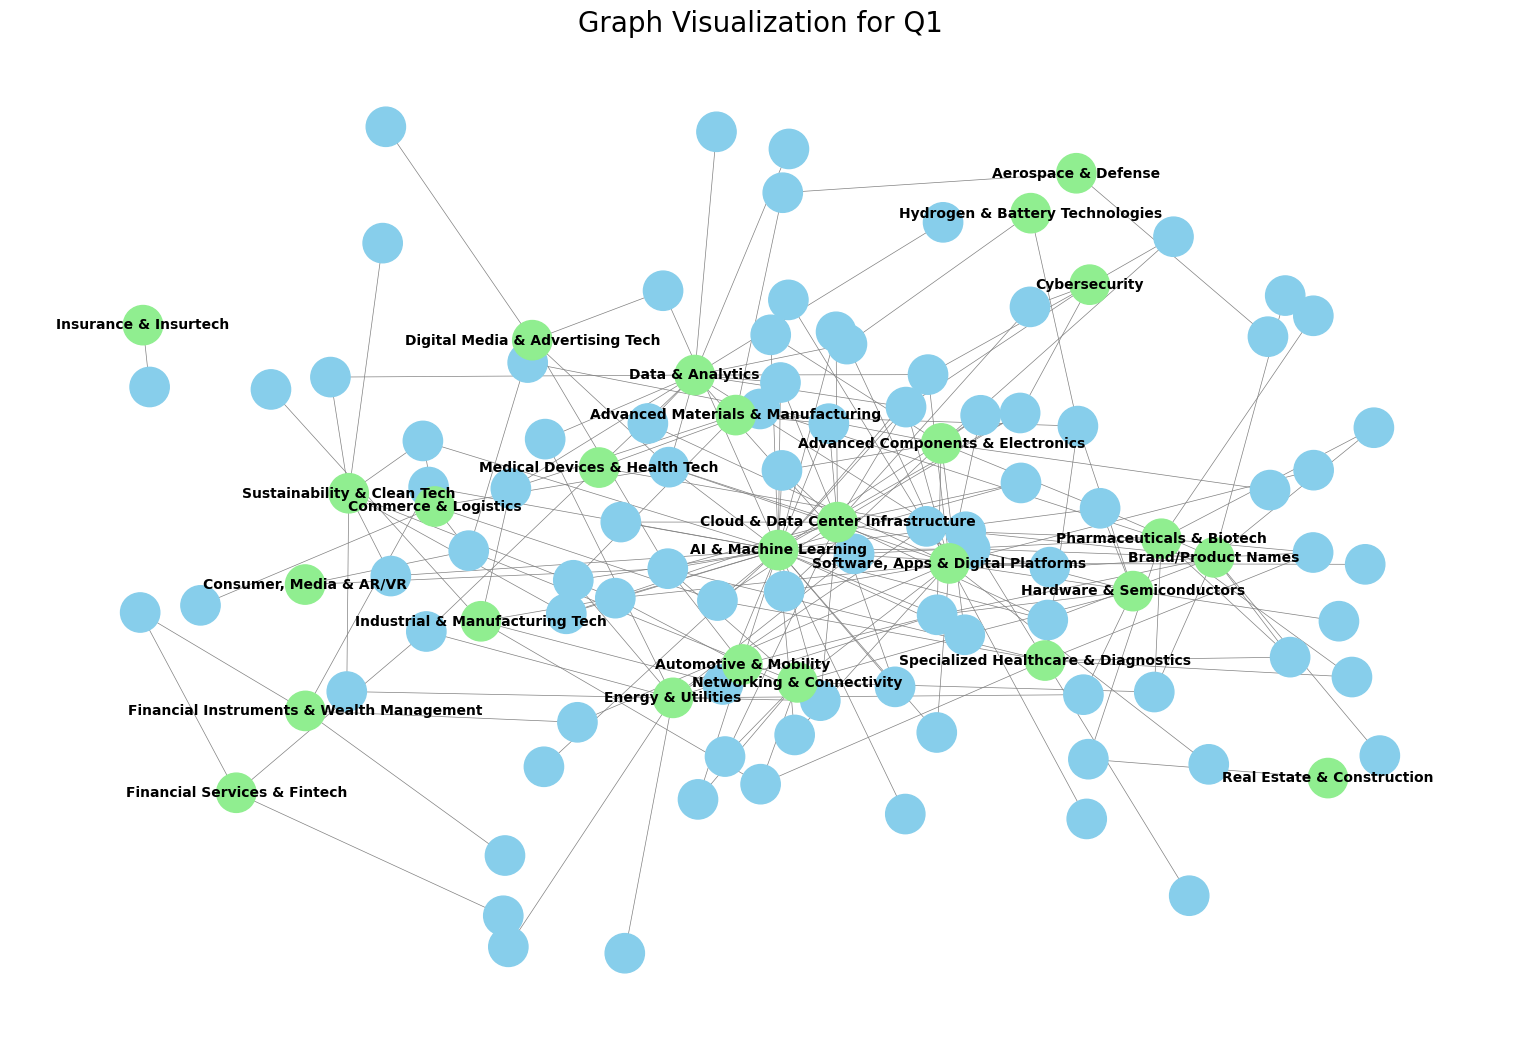

In [73]:


G = CompanyTechGraph_Q1


color_map = []
for node, data in G.nodes(data=True):
    if data.get('type') == 'Company':
        color_map.append('skyblue')  
    elif data.get('type') == 'Technology':
        color_map.append('lightgreen')  
    else:
        color_map.append('grey')
print("Color map generated.")


custom_labels = {}
for node, data in G.nodes(data=True):
    if data.get('type') == 'Technology':
        custom_labels[node] = node
        
print(f"Custom label dictionary created. It contains {len(custom_labels)} labels.")


plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.35, iterations=40, seed=42)


nx.draw(G,
        pos,
        node_color=color_map,
        labels=custom_labels,  
        node_size=800,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        width=0.5
       )

plt.title("Graph Visualization for Q1", fontsize=20)


In [76]:


print("Calculating Degree Centrality...")
deg_centrality = nx.degree_centrality(G)


between_centrality = nx.betweenness_centrality(G, normalized=True)

print("Calculating Eigenvector Centrality...")
try:
    eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector Centrality did not converge. Skipping.")
    eigen_centrality = {node: 0 for node in G.nodes()} # Create empty dict

print("Centrality calculations complete.")

# ---Combine Measures into a DataFrame ---

node_data = []
for node in G.nodes():
    data = G.nodes[node]
    node_data.append({
        'node': node,
        'type': data.get('type'),
        'degree': deg_centrality.get(node, 0),
        'betweenness': between_centrality.get(node, 0),
        'eigenvector': eigen_centrality.get(node, 0)
    })

# Create the DataFrame
df_centrality = pd.DataFrame(node_data)



df_companies = df_centrality[df_centrality['type'] == 'Company'].copy()
df_techs = df_centrality[df_centrality['type'] == 'Technology'].copy()

print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='degree', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='degree', ascending=False).head(3))





Calculating Degree Centrality...
Calculating Eigenvector Centrality...
Centrality calculations complete.

--- Top 3 Companies by Degree (Most Connected) ---
                            node     type    degree  betweenness  eigenvector
48            Best Buy Co., Inc.  Company  0.061947     0.055103     0.147145
6                     Adobe Inc.  Company  0.053097     0.057439     0.170627
24  Advanced Micro Devices, Inc.  Company  0.053097     0.067406     0.149776

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
90               AI & Machine Learning  Technology  0.318584     0.396600   
88  Software, Apps & Digital Platforms  Technology  0.168142     0.166003   
96  Cloud & Data Center Infrastructure  Technology  0.168142     0.094004   

    eigenvector  
90     0.527785  
88     0.196464  
96     0.303916  


In [77]:
print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='betweenness', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='betweenness', ascending=False).head(3))


--- Top 3 Companies by Degree (Most Connected) ---
                            node     type    degree  betweenness  eigenvector
62               Blackstone Inc.  Company  0.044248     0.100160     0.146157
24  Advanced Micro Devices, Inc.  Company  0.053097     0.067406     0.149776
6                     Adobe Inc.  Company  0.053097     0.057439     0.170627

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
90               AI & Machine Learning  Technology  0.318584     0.396600   
88  Software, Apps & Digital Platforms  Technology  0.168142     0.166003   
95                    Data & Analytics  Technology  0.132743     0.149466   

    eigenvector  
90     0.527785  
88     0.196464  
95     0.154216  


In [78]:
print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='eigenvector', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='eigenvector', ascending=False).head(3))


--- Top 3 Companies by Degree (Most Connected) ---
                            node     type    degree  betweenness  eigenvector
6                     Adobe Inc.  Company  0.053097     0.057439     0.170627
5                  Accenture plc  Company  0.044248     0.030540     0.164190
24  Advanced Micro Devices, Inc.  Company  0.053097     0.067406     0.149776

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
90               AI & Machine Learning  Technology  0.318584     0.396600   
96  Cloud & Data Center Infrastructure  Technology  0.168142     0.094004   
88  Software, Apps & Digital Platforms  Technology  0.168142     0.166003   

    eigenvector  
90     0.527785  
96     0.303916  
88     0.196464  


## Quarter 4

Adding 87 'Company' nodes...
Adding 27 'Technology' nodes...
Adding 314 'MENTIONS' edges...

✅ Company-Technology Graph built successfully!
Total nodes: 114
Total edges: 234
  - Company nodes found: 87
  - Technology nodes found: 27
Color map generated.
Custom label dictionary created. It contains 27 labels.


Text(0.5, 1.0, 'Graph Visualization for Q4')

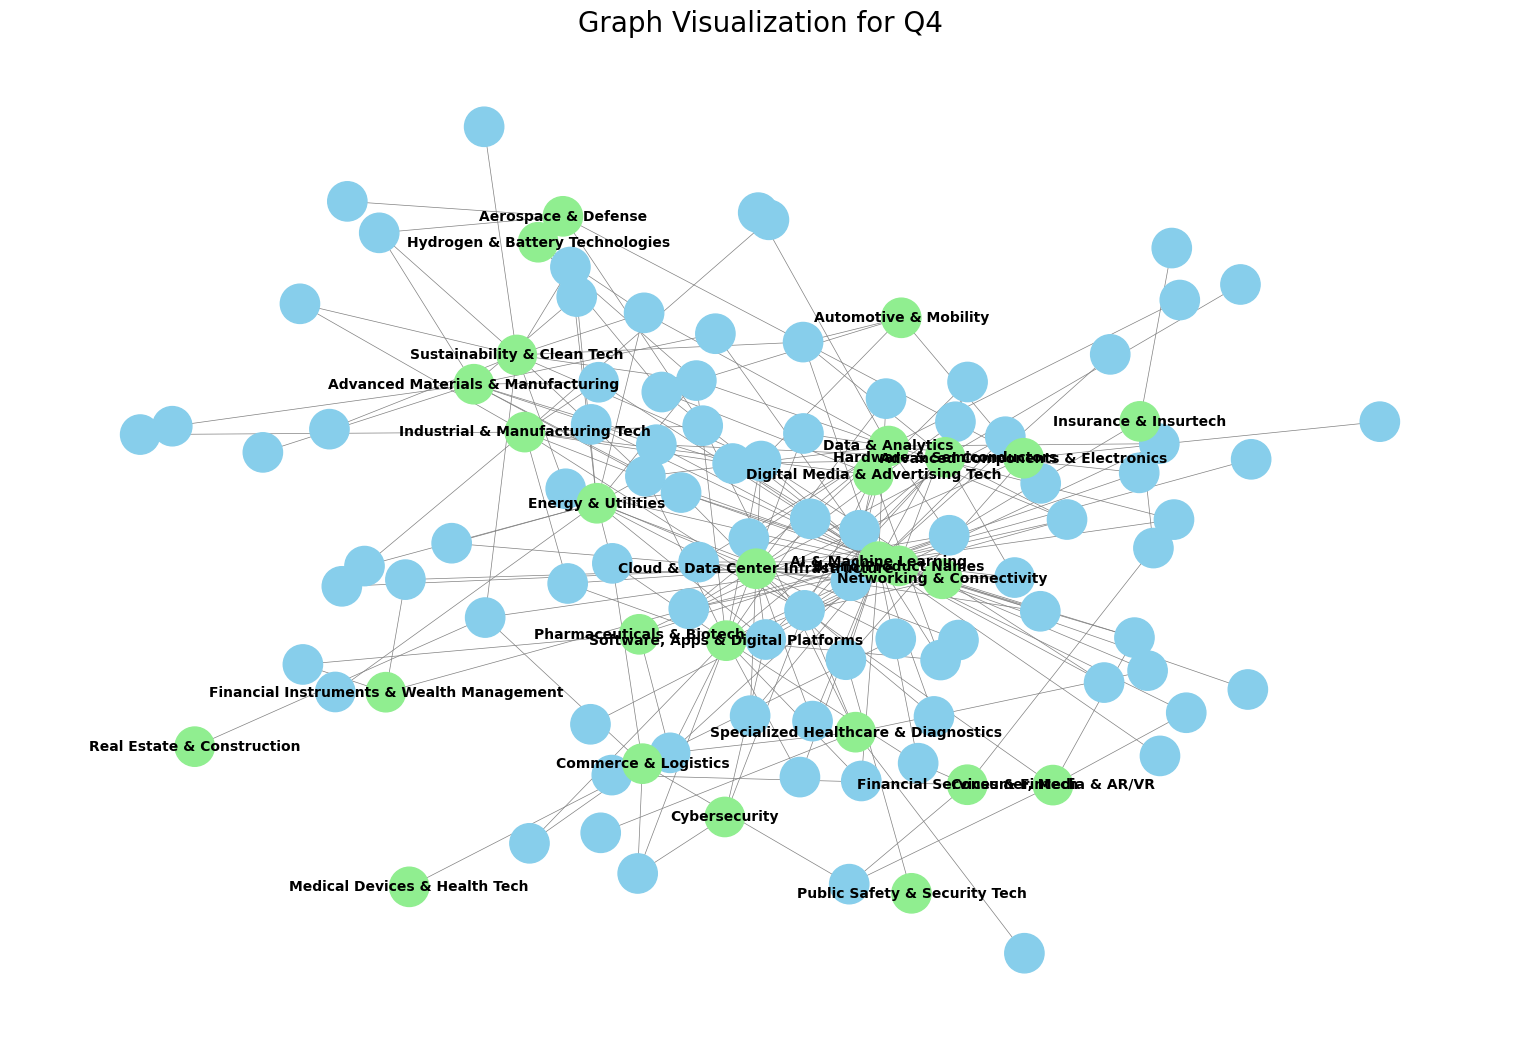

In [79]:

#building graph
CompanyTechGraph_Q4 = nx.Graph()



company_df = df_all_technologies_Q4[['company_name', 'symbol']].drop_duplicates()
print(f"Adding {len(company_df)} 'Company' nodes...")


for _, row in company_df.iterrows():
 
    CompanyTechGraph_Q4.add_node(
        row['company_name'],
        type='Company',
        symbol=row['symbol']
    )



tech_nodes = df_all_technologies_Q4['technology'].unique()
print(f"Adding {len(tech_nodes)} 'Technology' nodes...")

for tech_name in tech_nodes:
    CompanyTechGraph_Q4.add_node(
        tech_name,
        type='Technology'
    )


print(f"Adding {len(df_all_technologies_Q4)} 'MENTIONS' edges...")

for _, row in df_all_technologies_Q4.iterrows():
    CompanyTechGraph_Q4.add_edge(
        row['company_name'],
        row['technology'],
        type='MENTIONS',
        sentiment=row['technology_sentiment'],
        investment=row['investment_action'],
        profit_outlook=row['profit_outlook'],
        mentioned_by=row['mentioned_by'],
        year=row['year'],
        quarter=row['quarter']
    )

# --- 6. Print Summary ---
print(f"\n✅ Company-Technology Graph built successfully!")
print(f"Total nodes: {CompanyTechGraph_Q4.number_of_nodes():,}")
print(f"Total edges: {CompanyTechGraph_Q4.number_of_edges():,}")


company_nodes = [n for n, d in CompanyTechGraph_Q4.nodes(data=True) if d['type'] == 'Company']
tech_nodes = [n for n, d in CompanyTechGraph_Q4.nodes(data=True) if d['type'] == 'Technology']

print(f"  - Company nodes found: {len(company_nodes):,}")
print(f"  - Technology nodes found: {len(tech_nodes):,}")


G = CompanyTechGraph_Q4

# --- 2. Create a Color Map ---
color_map = []
for node, data in G.nodes(data=True):
    if data.get('type') == 'Company':
        color_map.append('skyblue')  # Color for companies
    elif data.get('type') == 'Technology':
        color_map.append('lightgreen')  # Color for technologies
    else:
        color_map.append('grey')
print("Color map generated.")


custom_labels = {}
for node, data in G.nodes(data=True):
    if data.get('type') == 'Technology':
        custom_labels[node] = node
        
print(f"Custom label dictionary created. It contains {len(custom_labels)} labels.")

# --- 4. Plot the Graph ---
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.35, iterations=40, seed=42)

# Draw the graph
nx.draw(G,
        pos,
        node_color=color_map,
        labels=custom_labels,  # <-- Use our custom label dictionary
        node_size=800,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        width=0.5
       )

plt.title("Graph Visualization for Q4", fontsize=20)

In [82]:

print("Calculating Degree Centrality...")
deg_centrality = nx.degree_centrality(G)


print("Calculating Betweenness Centrality...")

between_centrality = nx.betweenness_centrality(G, normalized=True)


print("Calculating Eigenvector Centrality...")
try:
    eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector Centrality did not converge. Skipping.")
    eigen_centrality = {node: 0 for node in G.nodes()} # Create empty dict

print("Centrality calculations complete.")


node_data = []
for node in G.nodes():
    data = G.nodes[node]
    node_data.append({
        'node': node,
        'type': data.get('type'),
        'degree': deg_centrality.get(node, 0),
        'betweenness': between_centrality.get(node, 0),
        'eigenvector': eigen_centrality.get(node, 0)
    })

df_centrality = pd.DataFrame(node_data)



df_companies = df_centrality[df_centrality['type'] == 'Company'].copy()
df_techs = df_centrality[df_centrality['type'] == 'Technology'].copy()




Calculating Degree Centrality...
Calculating Betweenness Centrality...
Calculating Eigenvector Centrality...
Centrality calculations complete.


In [83]:
print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='degree', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='degree', ascending=False).head(3))


--- Top 3 Companies by Degree (Most Connected) ---
                            node     type    degree  betweenness  eigenvector
7           Analog Devices, Inc.  Company  0.097345     0.115942     0.192231
35                     Aptiv PLC  Company  0.070796     0.057892     0.162849
70  Cadence Design Systems, Inc.  Company  0.061947     0.038059     0.153607

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
88               AI & Machine Learning  Technology  0.380531     0.441391   
87  Cloud & Data Center Infrastructure  Technology  0.194690     0.121364   
96                    Data & Analytics  Technology  0.159292     0.102415   

    eigenvector  
88     0.499817  
87     0.252274  
96     0.205821  


In [84]:
print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='betweenness', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='betweenness', ascending=False).head(3))


--- Top 3 Companies by Degree (Most Connected) ---
                    node     type    degree  betweenness  eigenvector
7   Analog Devices, Inc.  Company  0.097345     0.115942     0.192231
35             Aptiv PLC  Company  0.070796     0.057892     0.162849
61       Blackstone Inc.  Company  0.044248     0.056023     0.121890

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
88               AI & Machine Learning  Technology  0.380531     0.441391   
87  Cloud & Data Center Infrastructure  Technology  0.194690     0.121364   
95  Software, Apps & Digital Platforms  Technology  0.159292     0.103518   

    eigenvector  
88     0.499817  
87     0.252274  
95     0.211303  


In [85]:
print("\n--- Top 3 Companies by Degree (Most Connected) ---")
print(df_companies.sort_values(by='eigenvector', ascending=False).head(3))

print("\n--- Top 3 Technologies by Degree (Most Used) ---")
print(df_techs.sort_values(by='eigenvector', ascending=False).head(3))


--- Top 3 Companies by Degree (Most Connected) ---
                    node     type    degree  betweenness  eigenvector
7   Analog Devices, Inc.  Company  0.097345     0.115942     0.192231
6             Adobe Inc.  Company  0.053097     0.021706     0.166273
35             Aptiv PLC  Company  0.070796     0.057892     0.162849

--- Top 3 Technologies by Degree (Most Used) ---
                                  node        type    degree  betweenness  \
88               AI & Machine Learning  Technology  0.380531     0.441391   
87  Cloud & Data Center Infrastructure  Technology  0.194690     0.121364   
95  Software, Apps & Digital Platforms  Technology  0.159292     0.103518   

    eigenvector  
88     0.499817  
87     0.252274  
95     0.211303  
